# Requirments

## Import

In [1]:
import os
import random
import math
import csv
import json
from tqdm.notebook import tqdm
from easydict import EasyDict as edict
from statistics import mean
from typing import List, Tuple, Dict, Any

import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import wandb

import torch
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

from torchinfo import summary

from transformers import ElectraModel, ElectraTokenizer, ElectraForQuestionAnswering, AutoModelForQuestionAnswering, AutoTokenizer

In [2]:
for name in 'models', 'submissions':
    os.makedirs(name, exist_ok=True)

# Set Arguments, Hyper-parameters

In [3]:
args = edict({'w_project': 'test_project',
              'w_entity': 'chohs1221',
              'learning_rate': 6e-5,
              'batch_size': {'train': 256,
                             'eval': 16,
                             'test': 256},
              'accumulate': 64,
              'epochs': 10,
              'seed': 42,
              # 'model_name': 'monologg/koelectra-base-v3-discriminator',
              'model_name': 'monologg/kobigbird-bert-base',
              'max_length': 2048})
# args['NAME'] = ''f'koelectra_ep{args.epochs}_lr{args.learning_rate}_{random.randrange(0, 1024)}'
args['NAME'] = ''f'kobigbird_ep{args.epochs}_max{args.max_length}_lr{args.learning_rate}_{random.randrange(0, 1024)}'
print(args.NAME)

kobigbird_ep10_max2048_lr6e-05_42


# Initialize

## Wandb

In [4]:
wandb.login()

wandb: Currently logged in as: chohs1221 (use `wandb login --relogin` to force relogin)


True

In [5]:
wandb.init(project = args.w_project, entity = args.w_entity)

In [6]:
wandb.run.name = args.NAME
wandb.config.learning_rate = args.learning_rate
wandb.config.epochs = args.epochs
wandb.config.batch_size = args.batch_size

## Seed

In [7]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(args.seed)

## Tokenizer

In [8]:
# tokenizer = ElectraTokenizer.from_pretrained(args.model_name)
tokenizer = AutoTokenizer.from_pretrained(args.model_name)

## Model

In [9]:
# model = ElectraForQuestionAnswering.from_pretrained(args.model_name)
model = AutoModelForQuestionAnswering.from_pretrained(args.model_name)
# summary(model, (args.batch_size.train//args.accumulate, args.max_length), dtypes=['torch.IntTensor'], device='cpu')

Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdForQuestionAnswering: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'bert.pooler.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'bert.pooler.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BigBirdForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of 

In [10]:
model.cuda();

## Optimizer

In [11]:
optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate)

# Datasets

## Load, Split

In [12]:
class KoMRC:
    def __init__(self, data, indices: List[Tuple[int, int, int]]):
        self._data = data
        self._indices = indices


    # Json을 불러오는 메소드
    @classmethod
    def load(cls, file_path: str):
        with open(file_path, 'r', encoding='utf-8') as fd:
            data = json.load(fd)

        indices = []
        for d_id, document in enumerate(data['data']):
            for p_id, paragraph in enumerate(document['paragraphs']):
                for q_id, _ in enumerate(paragraph['qas']):
                    indices.append((d_id, p_id, q_id))
        
        return cls(data, indices)


    # 데이터 셋을 잘라내는 메소드
    @classmethod
    def split(cls, dataset, eval_ratio: float=.1):
        indices = list(dataset._indices)
        random.shuffle(indices)
        train_indices = indices[int(len(indices) * eval_ratio):]
        eval_indices = indices[:int(len(indices) * eval_ratio)]

        return cls(dataset._data, train_indices), cls(dataset._data, eval_indices)


    def __getitem__(self, index: int) -> Dict[str, Any]:
        d_id, p_id, q_id = self._indices[index]
        paragraph = self._data['data'][d_id]['paragraphs'][p_id]

        qa = paragraph['qas'][q_id]

        guid = qa['guid']

        context = paragraph['context'].replace('\n', 'n').replace('\xad', '')

        question = qa['question'].replace('\n', 'n').replace('\xad', '')

        answers = qa['answers']
        if answers != None:
            for a in answers:
                a['text'] = a['text'].replace('\n', 'n').replace('\xad', '')


        return {'guid': guid,
            'context': context,
            'question': question,
            'answers': answers
        }

    def __len__(self) -> int:
        return len(self._indices)

In [13]:
dataset = KoMRC.load('./datasets2/train.json')
train_dataset, dev_dataset = KoMRC.split(dataset)
print("Number of Samples:", len(dataset))
print("Number of Train Samples:", len(train_dataset))
print("Number of Dev Samples:", len(dev_dataset))
# print(dataset[0])
# print(train_dataset[0])
# print(dev_dataset[0])

Number of Samples: 12037
Number of Train Samples: 10834
Number of Dev Samples: 1203


## Tokenize & Tag Token Positions

In [14]:
class TokenizedKoMRC(KoMRC):
    def __init__(self, data, indices: List[Tuple[int, int, int]]) -> None:
        super().__init__(data, indices)
        self._tokenizer = tokenizer


    def _tokenize_with_position(self, sentence: str) -> List[Tuple[str, Tuple[int, int]]]:
        position = 0
        tokens = []

        sentence_tokens = []
        for word in sentence.split():
            if '[UNK]' in tokenizer.tokenize(word):
                sentence_tokens.append(word)
            else:
                sentence_tokens += tokenizer.tokenize(word)
        
        for morph in sentence_tokens:
            if len(morph) > 2:
                if morph[:2] == '##':
                    morph = morph[2:]

            position = sentence.find(morph, position)
            tokens.append((morph, (position, position + len(morph))))
            position += len(morph)
            
        return tokens
            

    def __getitem__(self, index: int) -> Dict[str, Any]:
        sample = super().__getitem__(index)
        # sample = {'guid': guid, 'context': context, 'question': question, 'answers': answers}

        context, position = zip(*self._tokenize_with_position(sample['context']))
        context, position = list(context), list(position)

        question = self._tokenizer.tokenize(sample['question'])

        if sample['answers'] is not None:
            answers = []
            for answer in sample['answers']:
                for start, (position_start, position_end) in enumerate(position):
                    if position_start <= answer['answer_start'] < position_end:
                        break
                else:
                    print(context, answer)
                    print(answer['guid'])
                    print(answer['answer_start'])
                    raise ValueError("No mathced start position")

                target = ''.join(answer['text'].split(' '))
                source = ''
                for end, morph in enumerate(context[start:], start):
                    source += morph
                    if target in source:
                        break
                else:
                    print(context, answer)
                    print(answer['guid'])
                    print(answer['answer_start'])
                    raise ValueError("No Matched end position")

                answers.append({'start': start, 'end': end})
                
        else:
            answers = None
        
        return {
            'guid': sample['guid'],
            'context_original': sample['context'],
            'context_position': position,
            'question_original': sample['question'],
            'context': context,
            'question': question,
            'answers': answers
        }

In [15]:
dataset = TokenizedKoMRC.load('./datasets2/train.json')
train_dataset, dev_dataset = TokenizedKoMRC.split(dataset)
print("Number of Samples:", len(dataset))
print("Number of Train Samples:", len(train_dataset))
print("Number of Dev Samples:", len(dev_dataset))
# print(dataset[0])
# print(train_dataset[0])
# print(dev_dataset[0])

Number of Samples: 12037
Number of Train Samples: 10834
Number of Dev Samples: 1203


In [16]:
sample = dev_dataset[0]
print(sample['context'][sample['answers'][0]['start']:sample['answers'][0]['end']+1])

['3', '만', '50', '00', '여', '명']


## Input

In [17]:
class Indexer:
    def __init__(self, vocabs: List[str], max_length: int=args.max_length):
        self.max_length = max_length
        self.vocabs = vocabs

    @property
    def vocab_size(self):
        return len(self.vocabs)
    @property
    def pad_id(self):
        return tokenizer.vocab['[PAD]']
    @property
    def unk_id(self):
        return tokenizer.vocab['[UNK]']
    @property
    def cls_id(self):
        return tokenizer.vocab['[CLS]']
    @property
    def sep_id(self):
        return tokenizer.vocab['[SEP]']


    def sample2ids(self, sample: Dict[str, Any],) -> Dict[str, Any]:
        context = [tokenizer.convert_tokens_to_ids(token) for token in sample['context']]
        question = [tokenizer.convert_tokens_to_ids(token) for token in sample['question']]

        context = context[:self.max_length-len(question)-3]             # Truncate context
        
        input_ids = [self.cls_id] + question + [self.sep_id] + context + [self.sep_id]
        token_type_ids = [0] * (len(question) + 1) + [1] * (len(context) + 2)

        if sample['answers'] is not None:
            answer = sample['answers'][0]
            start = min(len(question) + 2 + answer['start'], self.max_length - 1)
            end = min(len(question) + 2 + answer['end'], self.max_length - 1)
        else:
            start = None
            end = None

        return {
            'guid': sample['guid'],
            'context': sample['context_original'],
            'question': sample['question_original'],
            'position': sample['context_position'],
            'input_ids': input_ids,
            'token_type_ids': token_type_ids,
            'start': start,
            'end': end
        }

In [18]:
indexer = Indexer(list(tokenizer.vocab.keys()))
# print(indexer.sample2ids(dev_dataset[0]))

## Attention Mask

In [19]:
class IndexerWrappedDataset:
    def __init__(self, dataset: TokenizedKoMRC, indexer: Indexer) -> None:
        self._dataset = dataset
        self._indexer = indexer

    def __len__(self) -> int:
        return len(self._dataset)
    
    def __getitem__(self, index: int) -> Dict[str, Any]:
        sample = self._indexer.sample2ids(self._dataset[index])
        sample['attention_mask'] = [1] * len(sample['input_ids'])

        return sample

In [20]:
indexed_train_dataset = IndexerWrappedDataset(train_dataset, indexer)
indexed_dev_dataset = IndexerWrappedDataset(dev_dataset, indexer)

sample = indexed_dev_dataset[0]
# print('input_ids', sample['input_ids'])
# print('attention_mask', sample['attention_mask'])
# print('token_type_ids', sample['token_type_ids'])
# print('start', sample['start'])
# print('end', sample['end'])

## Collate

In [21]:
class Collator:
    def __init__(self, indexer: Indexer) -> None:
        self._indexer = indexer


    def __call__(self, samples: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        samples = {key: [sample[key] for sample in samples] for key in samples[0]}

        for key in 'start', 'end':
            if samples[key][0] is None:
                samples[key] = None
            else:
                samples[key] = torch.tensor(samples[key], dtype=torch.long)
        
        for key in 'input_ids', 'attention_mask', 'token_type_ids':
            samples[key] = pad_sequence([torch.tensor(sample, dtype=torch.long) for sample in samples[key]],
                                        batch_first=True,
                                        padding_value=self._indexer.pad_id)

        return samples

## Data Loader

In [22]:
collator = Collator(indexer)
train_loader = DataLoader(indexed_train_dataset,
                          batch_size = args.batch_size.train // args.accumulate,
                          shuffle = True,
                          collate_fn = collator,
                          num_workers = 2)

dev_loader = DataLoader(indexed_dev_dataset,
                        batch_size = args.batch_size.eval,
                        shuffle = False,
                        collate_fn = collator,
                        num_workers = 2)

In [23]:
batch = next(iter(dev_loader))
print(batch['input_ids'])
print(batch['input_ids'].shape)
print(list(batch.keys()))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
tensor([[    2,  6882, 13607,  ...,     0,     0,     0],
        [    2,  7641,  4811,  ...,     0,     0,     0],
        [    2,  8311,  8796,  ...,     0,     0,     0],
        ...,
        [    2,  8022,  4644,  ...,  3904,  7262,     3],
        [    2, 17169,  4583,  ...,     0,     0,     0],
        [    2,  8443,  7035,  ...,     0,     0,

# Train

## Empty Cuda Cache

In [24]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [25]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Train

In [26]:
train_losses = []
dev_losses = []

train_loss = []
dev_loss = []

loss_accumulate = 0.

best_model = [-1, int(1e9)]

for epoch in range(args.epochs):
    print("Epoch", epoch, '===============================================================================================================')

    # Train    
    progress_bar_train = tqdm(train_loader, desc='Train')
    for i, batch in enumerate(progress_bar_train, 1):
        del batch['guid'], batch['context'], batch['question'], batch['position']
        batch = {key: value.cuda() for key, value in batch.items()}
        
        start = batch.pop('start')
        end = batch.pop('end')
        
        output = model(**batch)

        start_logits = output.start_logits
        end_logits = output.end_logits
        
        loss = (F.cross_entropy(start_logits, start) + F.cross_entropy(end_logits, end)) / args.accumulate
        loss.backward()

        loss_accumulate += loss.item()

        del batch, start, end, start_logits, end_logits, loss
        
        if i % args.accumulate == 0:
            # clip_grad_norm_(model.parameters(), max_norm=1.)
            optimizer.step()
            optimizer.zero_grad(set_to_none=False)

            train_loss.append(loss_accumulate)
            progress_bar_train.set_description(f"Train - Loss: {loss_accumulate:.3f}")
            loss_accumulate = 0.
        else:
            continue

        if i % int(len(train_loader) / (args.accumulate * 25)) == 0:
            # Evaluation
            for batch in dev_loader:
                del batch['guid'], batch['context'], batch['question'], batch['position']
                batch = {key: value.cuda() for key, value in batch.items()}

                start = batch.pop('start')
                end = batch.pop('end')
                
                model.eval()
                with torch.no_grad():
                    output = model(**batch)
                
                    start_logits = output.start_logits
                    end_logits = output.end_logits
                model.train()

                loss = F.cross_entropy(start_logits, start) + F.cross_entropy(end_logits, end)

                dev_loss.append(loss.item())

                del batch, start, end, start_logits, end_logits, loss

            train_losses.append(mean(train_loss))
            dev_losses.append(mean(dev_loss))
            train_loss = []
            dev_loss = []

            
            if dev_losses[-1] <= best_model[1]:
                best_model = (epoch, dev_losses[-1])
                model.save_pretrained(f'models/{args.NAME}_{epoch}')
                # print(f'model saved!!\nvalid_loss: {dev_losses[-1]}')
                
            wandb.log({"train_loss": train_losses[-1],
                       "valid_loss": dev_losses[-1]})
            

    print(f"Train Loss: {train_losses[-1]:.3f}")
    print(f"Valid Loss: {dev_losses[-1]:.3f}")
    print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')


Epoch 0 ===============================================================================================================


Attention type 'block_sparse' is not possible if sequence_length: 658 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


model saved!!
valid_loss: 12.203485689665142
model saved!!
valid_loss: 11.061726243872391
model saved!!
valid_loss: 10.115518783268175
model saved!!
valid_loss: 9.464702957554868
model saved!!
valid_loss: 9.067599591455961
model saved!!
valid_loss: 8.873669649425306
model saved!!
valid_loss: 8.81695785020527
model saved!!
valid_loss: 8.653418892308286
model saved!!
valid_loss: 8.452049299290305
model saved!!
valid_loss: 8.282918403023167
model saved!!
valid_loss: 8.114238262176514
model saved!!
valid_loss: 7.842631590993781
model saved!!
valid_loss: 7.473345405177066
model saved!!
valid_loss: 7.06651527003238
model saved!!
valid_loss: 6.6626502840142505
model saved!!
valid_loss: 6.3321145271000105
model saved!!
valid_loss: 6.002478605822513
model saved!!
valid_loss: 5.702788873722679
model saved!!
valid_loss: 5.407888139549055
model saved!!
valid_loss: 5.211233380593751
model saved!!
valid_loss: 5.058772328652833
model saved!!
valid_loss: 4.887976028417286
model saved!!
valid_loss: 4.7

model saved!!
valid_loss: 3.2172157607580485
model saved!!
valid_loss: 3.1870999822491095
model saved!!
valid_loss: 3.1763404215637006
model saved!!
valid_loss: 3.1547224254984605
model saved!!
valid_loss: 3.124866396188736
model saved!!
valid_loss: 3.0791960656642914
model saved!!
valid_loss: 3.0155253473081087
model saved!!
valid_loss: 2.965442086520948
model saved!!
valid_loss: 2.9534293868039785
model saved!!
valid_loss: 2.9505601384137807
model saved!!
valid_loss: 2.9349668465162577
model saved!!
valid_loss: 2.8981114171053233
model saved!!
valid_loss: 2.848263704463055
model saved!!
valid_loss: 2.826626412178341
model saved!!
valid_loss: 2.8078490072175075
model saved!!
valid_loss: 2.8006795676130998
model saved!!
valid_loss: 2.7892385642779502
model saved!!
valid_loss: 2.7829694167563788
model saved!!
valid_loss: 2.7643002240281356
model saved!!
valid_loss: 2.748023183722245
model saved!!
valid_loss: 2.731843945227171
model saved!!
valid_loss: 2.722629445163827
model saved!!
val

model saved!!
valid_loss: 2.499104733529844
model saved!!
valid_loss: 2.489091844935166

Train Loss: 1.444
Valid Loss: 2.518
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Epoch 3 ===============================================================================================================



Train Loss: 0.873
Valid Loss: 2.820
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Epoch 4 ===============================================================================================================



Train Loss: 0.706
Valid Loss: 3.007
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Epoch 5 ===============================================================================================================



Train Loss: 0.464
Valid Loss: 3.281
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Epoch 6 ===============================================================================================================


wandb: Network error (ReadTimeout), entering retry loop.



Train Loss: 0.410
Valid Loss: 3.699
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Epoch 7 ===============================================================================================================



Train Loss: 0.265
Valid Loss: 4.003
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Epoch 8 ===============================================================================================================



Train Loss: 0.312
Valid Loss: 4.214
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Epoch 9 ===============================================================================================================



Train Loss: 0.190
Valid Loss: 3.810
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


## Visualize Training

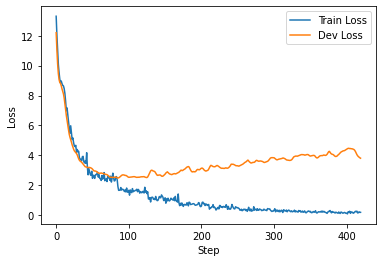

In [27]:
plt.plot(train_losses, label="Train Loss")
plt.plot(dev_losses, label="Dev Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Test

## Datasets

In [28]:
test_dataset = TokenizedKoMRC.load('./datasets2/test.json')
indexer_test = Indexer(list(tokenizer.vocab.keys()))
indexed_test_dataset = IndexerWrappedDataset(test_dataset, indexer_test)
print("Number of Test Samples", len(test_dataset))
# print(test_dataset[0])

Number of Test Samples 4008


## Model

In [37]:
best_model[0]

2

Exception in thread NetStatThr:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 152, in check_network_status
    status_response = self._interface.communicate_network_status()
  File "/opt/conda/lib/python3.8/site-packages/wandb/sdk/interface/interface.py", line 125, in communicate_network_status
    resp = self._communicate_network_status(status)
  File "/opt/conda/lib/python3.8/site-packages/wandb/sdk/interface/interface_shared.py", line 404, in _communicate_network_status
    resp = self._communicate(req, local=True)
  File "/opt/conda/lib/python3.8/site-packages/wandb/sdk/interface/interface_shared.py", line 225, in _communicate
    return self._communicate_async(rec, local=local).get(timeout=timeout)
  File "/opt/cond

In [29]:
model = AutoModelForQuestionAnswering.from_pretrained(f'models/{args.NAME}_{best_model[0]}')
model.cuda();
# summary(model, (args.batch_size.train//args.accumulate, args.max_length), dtypes=['torch.IntTensor'], device='cpu')

In [30]:
for idx, sample in zip(range(1, 4), indexed_train_dataset):
    print(f'------{idx}------')
    print('Context:', sample['context'])
    print('Question:', sample['question'])
    
    input_ids, token_type_ids = [
        torch.tensor(sample[key], dtype=torch.long, device="cuda")
        for key in ("input_ids", "token_type_ids")
    ]
    
    model.eval()
    with torch.no_grad():
        output = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :])

    start_logits = output.start_logits
    end_logits = output.end_logits
    start_logits.squeeze_(0), end_logits.squeeze_(0)
    
    start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
    end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)

    probability = torch.triu(start_prob[:, None] @ end_prob[None, :])

    index = torch.argmax(probability).item()
    
    start = index // len(end_prob)
    end = index % len(end_prob)
    
    start_str = sample['position'][start][0]
    end_str = sample['position'][end][1]

    print('Answer:', sample['context'][start_str:end_str])

Attention type 'block_sparse' is not possible if sequence_length: 483 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


------1------
Context: 1조3000억원에 달하는 사기성 기업어음(CP)을 발행해 투자자들에게 손해를 끼친 혐의 등으로 기소된 현재현 동양그룹 회장(65·사진)에게 징역 12년형이 선고됐다. 이는 역대 형사재판에 넘겨진 재벌 총수 중 두 번째로 무거운 형이다.서울중앙지법 형사합의25부(부장판사 위현석)는 17일 오후 열린 현 회장에 대한 선고 공판에서 “피해자가 4만명에 달하고 피해 금액도 유례를 찾아보기 힘든 대규모 기업범죄로 엄중한 책임을 묻지 않을 수 없다”며 이같이 선고했다. 함께 기소된 정진석 전 동양증권 사장은 징역 5년을, 김철 전 동양네트웍스 대표와 이상화 전 동양인터내셔널 대표는 각각 징역 4년과 3년6월을 선고받았다. 검찰은 앞서 현 회장에게 징역 15년형을 구형했다.재판부는 현 회장에게 적용된 1조2985억원의 사기성 CP 등 발행 혐의와 141억원대 횡령 혐의를 유죄로 판단했다. 재판부는 “피고인들은 CP 발행 당시 자력으로 만기상환하는 것은 불가능하다는 점을 알고 있었다”며 “현 회장은 그룹의 지배구조에 집착한 나머지 일반투자자를 상대로 기망적 수단과 방법을 동원해 CP와 회사채를 발행했다”고 지적했다. 이어 “이로 인해 경영과 아무런 관계가 없는 다수의 피해자가 막대한 경제적·정신적 피해를 입었다”며 “범행을 부인하며 반성하지 않고, 피해 회복을 위한 노력도 하지 않아 중형을 선고하지 않을 수 없다”고 말했다. 다만 시세조종 혐의와 6000억원대 배임 혐의에 대해서는 일부 유죄로, 회계 부정과 허위 재무제표 공시 혐의는 무죄로 판단했다.현 회장이 받은 징역 12년형은 역대 형사재판에 넘겨진 재벌 총수 중 두 번째로 높은 형이다. 최고형은 1997년 한보사태 때 정태수 전 한보그룹 회장이 받은 징역 15년형이다.
Question: 재벌총수 중 지금까지 가장 높은 형량을 받은 사람의 이름은?
Answer: 정태수
------2------
Context: 제닉스 스튜디오(대표 이일희)는 블록체인 기반 IoT 플랫폼 ‘젠서(x

## Evaluate

In [31]:
start_visualize = []
end_visualize = []

with torch.no_grad(), open(f'submissions/{args.NAME}.csv', 'w') as fd:
    writer = csv.writer(fd)
    writer.writerow(['Id', 'Predicted'])

    rows = []
    c = 0
    # for sample in tqdm(test_dataset, "Testing"):
    for sample in tqdm(indexed_test_dataset, "Testing"):
        input_ids, token_type_ids = [torch.tensor(sample[key], dtype=torch.long, device="cuda") for key in ("input_ids", "token_type_ids")]
        # print(sample)
    
        model.eval()
        with torch.no_grad():
            output = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :])

        start_logits = output.start_logits
        end_logits = output.end_logits
        start_logits.squeeze_(0), end_logits.squeeze_(0)

        start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
        end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)

        probability = torch.triu(start_prob[:, None] @ end_prob[None, :])

        # 토큰 길이 8까지만
        for row in range(len(start_prob) - 8):
            probability[row] = torch.cat((probability[row][:8+row].cpu(), torch.Tensor([0] * (len(start_prob)-(8+row))).cpu()), 0)

        index = torch.argmax(probability).item()

        start = index // len(end_prob)
        end = index % len(end_prob)
        
        # 확률 너무 낮으면 자르기
        if start_prob[start] > 0.3 and end_prob[end] > 0.3:
            start_str = sample['position'][start][0]
            end_str = sample['position'][end][1]
        else:
            start_str = 0
            end_str = 0

        start_visualize.append((list(start_prob.cpu()), (start, end), (start_str, end_str)))
        end_visualize.append((list(end_prob.cpu()), (start, end), (start_str, end_str)))
        
        rows.append([sample["guid"], sample['context'][start_str:end_str]])

    writer.writerows(rows)

## Visualize Evaluation

<ipython-input-32-5285ffb1187d>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  start_visualize = np.array(start_visualize)
<ipython-input-32-5285ffb1187d>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  end_visualize = np.array(end_visualize)


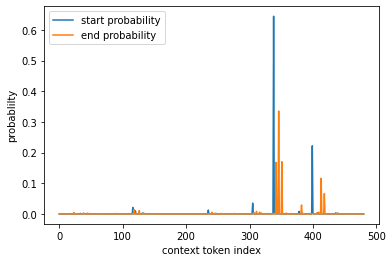

token position: (338, 342)
context position: (0, 0)


In [32]:
idx = 0

start_visualize = np.array(start_visualize)
end_visualize = np.array(end_visualize)

start_probalilities, token_pos, str_pos = start_visualize[:,0], start_visualize[:,1], start_visualize[:,2]
end_probalilities, token_pos, str_pos = end_visualize[:,0], end_visualize[:,1], end_visualize[:,2]

plt.plot(start_probalilities[idx], label="start probability")
plt.plot(end_probalilities[idx], label="end probability")
plt.xlabel("context token index")
plt.ylabel("probablilty")
plt.legend()
plt.show()

print('token position:', token_pos[idx])
print('context position:', str_pos[idx])

1 294 298


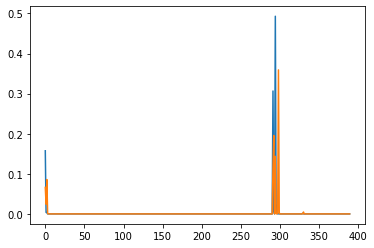

In [33]:
for i, (start, end) in enumerate(token_pos):
    if end - start > 1:
        if i > 0:
            plt.plot(start_probalilities[i])
            plt.plot(end_probalilities[i])
            print(i, start, end)
            break

2.1197604790419162


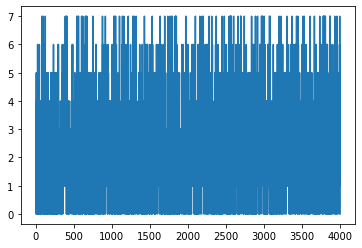

In [34]:
temp = []
h = 0
l = 100
for i, (start, end) in enumerate(token_pos):
    h = max(h, end - start)
    l = min(l ,end - start)
    temp.append(end - start)
plt.plot(temp)
print(mean(temp))

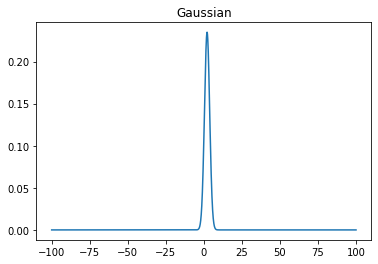

In [35]:
mu = mean(temp)
sigma = math.sqrt(np.var(temp))
x = np.linspace(-100, 100, len(temp))
g = (1 / np.sqrt(2*np.pi * sigma**2)) * np.exp(- (x-mu)**2 / (2*sigma**2))
plt.title('Gaussian')
plt.plot(x, g)

In [36]:
z = [(i-mu)/sigma for i in temp]
print(f'평균: {round(mean(z), 9)}')
print(f'표준편차: {math.sqrt(np.var(z))}')
print('-----90%------')
print(mu - 1.645*sigma/math.sqrt(len(temp)))
print(mu + 1.645*sigma/math.sqrt(len(temp)))
print('-----95%------')
print(mu - 1.96*sigma/math.sqrt(len(temp)))
print(mu + 1.96*sigma/math.sqrt(len(temp)))
print('-----99%------')
print(mu - 2.576*sigma/math.sqrt(len(temp)))
print(mu + 2.576*sigma/math.sqrt(len(temp)))

평균: 0.0
표준편차: 1.0000000000000002
-----90%------
2.0756044927435378
2.1639164653402947
-----95%------
2.0671490911119332
2.172371866971899
-----99%------
2.050614083476796
2.1889068746070364
